# JAX vs NumPy

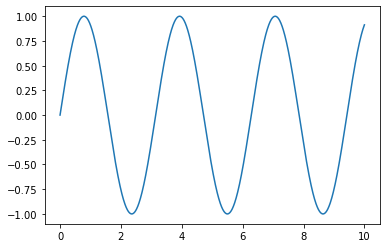

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)

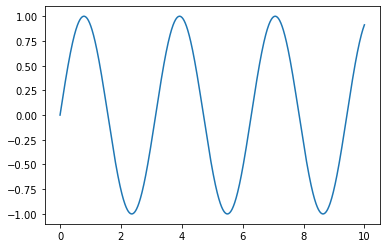

In [2]:
import jax.numpy as jnp

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

#### JAX arrays are immutable

In [3]:
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


In [4]:
x = jnp.arange(10)
x[0] = 10

TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable; perhaps you want jax.ops.index_update or jax.ops.index_add instead?

In [5]:
y = x.at[0].set(10)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[10  1  2  3  4  5  6  7  8  9]


# NumPy, lax & XLA: JAX API layering

In [6]:
import jax.numpy as jnp

In [7]:
jnp.add(1, 1.0)

DeviceArray(2., dtype=float32)

In [8]:
from jax import lax
lax.add(1, 1.9)

TypeError: add requires arguments to have the same dtypes, got int32, float32.

In [9]:
lax.add(jnp.float32(1), 1.9)

DeviceArray(2.9, dtype=float32)

#### for 1D convolution,

In [10]:
x = jnp.array([1, 2, 1])
y = jnp.ones(10)
jnp.convolve(x, y)

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

In [12]:
result = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)])
result[0, 0]

DeviceArray([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

# To JIT or not to JIT

In [13]:
import jax.numpy as jnp

def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

In [14]:
from jax import jit
norm_compiled = jit(norm)

In [15]:
np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
np.allclose(norm(X), norm_compiled(X), atol=1E-6)

True

#### JIT requires all arrays to have static shapes

In [16]:
def get_negatives(x):
    return x[x < 0]

x = jnp.array(np.random.randn(10))
get_negatives(x)

DeviceArray([-0.10570311, -0.59403396, -0.8680282 , -0.23489487], dtype=float32)

In [18]:
jit(get_negatives)(x)

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[10])
 (https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError)

# JIT mechanics: tracing and static variables

In [19]:
@jit
def f(x, y):
    print("Running f():")
    print(f"  x = {x}")
    print(f"  y = {y}")
    result = jnp.dot(x + 1, y + 1)
    print(f"  result = {result}")
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
f(x, y)

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=0/1)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>


DeviceArray([0.25773212, 5.3623195 , 5.4032435 ], dtype=float32)

#### print does not work because f() is computed in XLA

In [20]:
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
f(x2, y2)

DeviceArray([1.4344587, 4.3004417, 7.989701 ], dtype=float32)

In [21]:
from jax import make_jaxpr

def f(x, y):
    return jnp.dot(x + 1, y + 1)

make_jaxpr(f)(x, y)

{ lambda  ; a b.
  let c = add a 1.0
      d = add b 1.0
      e = dot_general[ dimension_numbers=(((1,), (0,)), ((), ()))
                       precision=None
                       preferred_element_type=None ] c d
  in (e,) }

In [36]:
@jit
def f(x, neg):
    return -x if neg else x

f(1, True)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
While tracing the function f at <ipython-input-36-327480aab76f>:1, transformed by jit., this concrete value was not available in Python because it depends on the value of the arguments to f at <ipython-input-36-327480aab76f>:1, transformed by jit. at flattened positions [1], and the computation of these values is being staged out (that is, delayed rather than executed eagerly).
 (https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError)

#### Mark as static for control flow statements

In [37]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
    return -x if neg else x

f(1, True)

DeviceArray(-1, dtype=int32)

Note that calling a JIT-compiled function with a different static argument results in re-compilation, so the function still works as expected:

In [38]:
f(1, False)

DeviceArray(1, dtype=int32)

In [39]:
%timeit f(1, True)

56.2 µs ± 1.89 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### test

In [41]:
def no_jit_f(x, neg):
    return -x if neg else x

no_jit_f(1, True)

-1

In [42]:
%timeit no_jit_f(1, True)

62.7 ns ± 0.187 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


# Static vs Traced Operations

In [44]:
import jax.numpy as jnp
from jax import jit

@jit
def f(x):
    return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2, 3))
f(x)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got [Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.

In [45]:
@jit
def f(x):
    print(f"x = {x}")
    print(f"x.shape = {x.shape}")
    print(f"jnp.array(x.shape).prod() = {jnp.array(x.shape).prod()}")
    
f(x)

x = Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=0/1)>
x.shape = (2, 3)
jnp.array(x.shape).prod() = Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>


x.shape is a static value. 

In [46]:
from jax import jit
import jax.numpy as jnp
import numpy as np

@jit
def f(x):
    return x.reshape((np.prod(x.shape),))

f(x)

DeviceArray([1., 1., 1., 1., 1., 1.], dtype=float32)